In [ ]:
!python --version

#!pip uninstall -y yfinance
!pip3 install yfinance
!pip3 install hurst


Python 3.11.11


In [ ]:
import yfinance as yf
import pandas as pd
import math
import numpy as np
import requests
#import hurst as hs
from scipy.stats import linregress
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# # Getting all the S&P500 tickers from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
table = pd.read_html(url)
tickers = list(table[0]["Symbol"])
valid_tickers = [ticker for ticker in tickers if not ticker in ['BF.B', 'SW', 'AMTM', 'GEV', 'SOLV', 'BRK.B']]

In [ ]:
# Importing data of all S&P500 companies from Yahoo!Finance
start_date = "2013-01-01" # Made change from 2013 to 2022
end_date = "2023-12-31"

data = yf.download('TSLA', start_date, end_date, auto_adjust=False)
data.head()
type(data)

[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['TSLA']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


pandas.core.frame.DataFrame

# Data

In [ ]:
# Handle Missing Data
data = data.ffill().bfill()

# Align data
data = data.dropna(how='any')

In [ ]:
# Finding out the available datapoints categories in our dataset
data.columns.levels[0]

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')

In [ ]:
# Adjusted CLosing Price

ticker = ['TSLA']
adj_close_SP500 = data["Adj Close"][ticker]
print(adj_close_SP500.head())

# Volume
volumes_SP500 = data["Volume"]

# Log Returns
log_returns = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

# MACD
ema12 = adj_close_SP500.ewm(span=12, adjust=False).mean()
ema26 = adj_close_SP500.ewm(span=26, adjust=False).mean()
macd = ema12 - ema26

Empty DataFrame
Columns: [TSLA]
Index: []


# Hurst Exponent

The `hurst_exponent` function calculates the **Hurst exponent** of a time series using the **Rescaled Range (R/S) Analysis** method. The Hurst exponent is a measure of long-term memory and persistence in time series data, with values ranging from 0 to 1.

The function divides the input time series (`ts`) into overlapping segments of varying lengths (determined by `min_window` and `max_window`). For each segment, it calculates the **Rescaled Range (R/S)** by first finding the cumulative deviation of the segment from its mean, determining the range (`R`) of the cumulative deviation, and scaling it by the standard deviation (`S`). The function then computes the average R/S values for each segment size and logs these values along with the segment sizes. Finally, it performs a linear regression on the logarithmic values of segment sizes and R/S values, returning the slope of the regression line as the estimated **Hurst exponent**.

The Hurst exponent's value provides insights into the behavior of the time series:
- **H < 0.5**: Anti-persistent (mean-reverting).
- **H = 0.5**: Random walk (no memory).
- **H > 0.5**: Persistent (trending behavior).

This function is critical in financial and scientific analysis to determine if a time series is trending, mean-reverting, or random.

In [ ]:
def hurst_exponent(ts, min_window=10, max_window=None):
    """
    Calculate the Hurst exponent using Rescaled Range (R/S) Analysis with robust checks.
    """
    if len(ts) < min_window:
        return np.nan  # Case for insufficient data

    if max_window is None:
        max_window = len(ts) // 2

    log_returns = np.log(ts / ts.shift(1)).dropna()
    log_returns = log_returns.values

    segment_sizes = np.arange(min_window, max_window, step=(max_window - min_window) // 10)
    rs_values = []

    for n in segment_sizes:
        num_segments = len(log_returns) // n    # No. of full segments
        rs = []

        for k in range(num_segments):
          segment = log_returns[k * n : (k+1) * n]
          mean_adjusted = segment - segment.mean()    # Mean-adjusted

          cum_dev = np.cumsum(mean_adjusted)   # Cumulative sum of mean-adjusted returns

          # Range & S.D.
          R = cum_dev.max() - cum_dev.min()
          S = np.std(segment)

          if S > 0:
            rs.append(R / S)         # Avoid division by zero

        if len(rs) > 0:
          rs_values.append(np.mean(rs))    # Avg. R/S for segment size
        else:
          rs_values.append(np.nan)


    log_n = np.log(segment_sizes)
    log_rs = np.log(rs_values)

    valid_indices = np.isfinite(log_n) & np.isfinite(log_rs)
    if valid_indices.sum() < 2:
        return np.nan  # Not enough valid data points for regression

    slope, _, _, _, _ = linregress(log_n[valid_indices], log_rs[valid_indices])     # OLS Regression

    # Constrain the Hurst exponent to [0, 1]
    return slope

The `calculate_hurst_rolling` function computes the **rolling Hurst exponent** for each stock (or time series) in a given DataFrame over a specified window size. The Hurst exponent provides insight into the long-term memory and behavior of a time series, indicating whether it is trending, mean-reverting, or random.

This function takes as input:
1. A **DataFrame** (`data`) containing adjusted close prices of multiple stocks, with rows representing time and columns representing individual stock tickers.
2. A **rolling window size** (`window`) that determines the number of data points to include in each Hurst calculation.

For each stock (column) in the DataFrame:
1. The function applies a rolling window operation, where for every subset of the time series within the window, it calculates the **Hurst exponent** using the previously defined `hurst_exponent` function.
2. The calculated Hurst values are stored in a new DataFrame (`hurst_df`), with the same structure as the input data.

The result is a DataFrame containing the **rolling Hurst exponent values** for each stock, indexed by time.

In [ ]:
def calculate_rolling_hurst(data, window=60, min_window=10):
    """
      Calculate the rolling Hurst exponent for a DataFrame.

      Parameters:
          data (pd.DataFrame): Adjusted close prices of stocks.
          window (int): Rolling window size for Hurst exponent calculation.

      Returns:
          pd.DataFrame: DataFrame with rolling Hurst exponent values.
      """
    def process_column(column):
        ts = data[column].dropna()
        if len(ts) < window:
            return [np.nan] * len(data)
        rolling_hurst = ts.rolling(window).apply(lambda x: hurst_exponent(x, min_window=min_window), raw=False)
        return rolling_hurst

    # Parallelise the rolling Hurst exponent calculation across columns
    results = Parallel(n_jobs=-1)(delayed(process_column)(col) for col in data.columns)
    hurst_df = pd.DataFrame({col: result for col, result in zip(data.columns, results)}, index=data.index)
    return hurst_df

In [ ]:
# Calculate 60-day rolling Hurst exponent for S&P500 Stocks
hurst_rolling = calculate_rolling_hurst(adj_close_SP500, window=60)

print(hurst_rolling)
hurst_rolling.to_csv('hurst_rolling_aapl.csv')

Empty DataFrame
Columns: [TSLA]
Index: []


The `smooth_series` function applies a **moving average** over a given time series to reduce short-term fluctuations and smooth out noise. In the context of the **rolling Hurst exponent**, the function cleans up the raw output, which can often appear erratic due to high-frequency market volatility. By averaging values over a specified window size, the function makes it easier to interpret whether the market is trending, mean-reverting, or behaving randomly.

 While this basic smoothing technique provides an initial layer of noise reduction, **Kalman noise filtering** will be applied later to achieve more advanced and adaptive noise reduction, ensuring that the rolling Hurst exponent reflects a clearer, more accurate signal for analysis and decision-making.

In [ ]:
def smooth_series(series, window=10):
    """
    Apply a moving average to smooth out the series.
    """
    return series.rolling(window=window, center=True).mean()

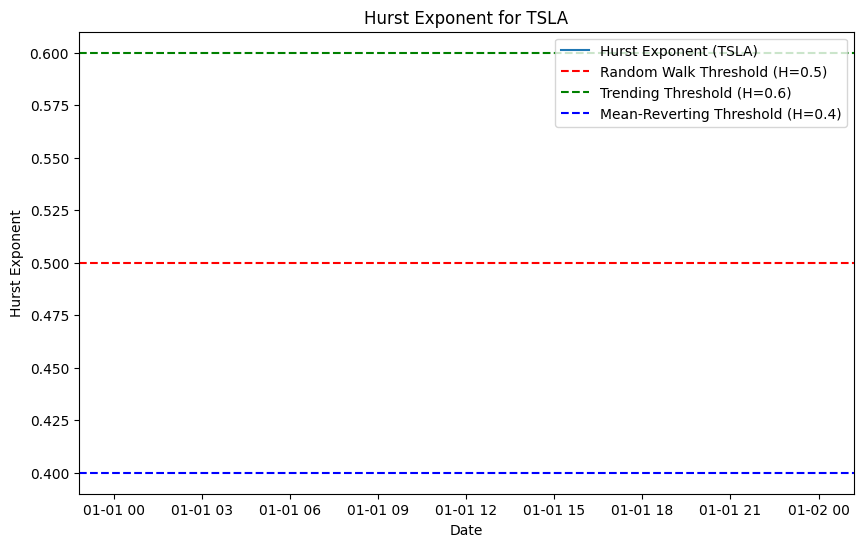

In [ ]:
ticker = "TSLA"
hurst_rolling_smoothed = hurst_rolling[ticker].copy()
hurst_rolling_smoothed = smooth_series(hurst_rolling_smoothed, window=10)

plt.figure(figsize=(10, 6))
plt.plot(hurst_rolling.index, hurst_rolling_smoothed, label=f"Hurst Exponent ({ticker})")
plt.axhline(0.5, color='red', linestyle='--', label='Random Walk Threshold (H=0.5)')
plt.axhline(0.6, color='green', linestyle='--', label='Trending Threshold (H=0.6)')
plt.axhline(0.4, color='blue', linestyle='--', label='Mean-Reverting Threshold (H=0.4)')
plt.title(f"Hurst Exponent for {ticker}")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent")
plt.legend()
plt.show()

In [ ]:
# Kalman filtering for Hurst exponent to reduce noise in signals

# Reference used: https://web.stanford.edu/class/ee363/lectures/kf.pdf

# Note: np.dot and @ for numpy does the same operation (Matrix multiplication)

# TODO: Add comments

class KalmanFilter:
  def __init__(self, process_noise=1e-5, measurement_noise=0.01, init_hurst_val=0.5):
    """
    Initializes the Kalman Filter with default noise values and an initial estimate.

    Parameters:
        process_noise (float):
            The process noise covariance. A small positive value ensures smooth hurst exponent value evolution.
        measurement_noise (float):
            The measurement noise covariance. Represents the uncertainty in the observations.
        init_hurst_val (float):
            Initial estimate of the Hurst exponent.
    """
    self.hurst_val = np.array([[init_hurst_val]])
    self.cov = np.array([[1]])
    self.hurst_transition = np.array([[1]])
    self.measurement = np.array([[1]])
    self.cov_noise = np.array([[process_noise]])
    self.measurement_noise = np.array([[measurement_noise]])
    self.kalman_gain = np.array([[1]])

  def predict(self):
    self.hurst_val = np.dot(self.hurst_transition, self.hurst_val)
    self.cov = np.dot(np.dot(self.hurst_transition, self.cov), self.hurst_transition.T) + self.cov_noise

  def update(self, measurement):
    self.kalman_gain = np.dot(np.dot(self.cov, self.measurement.T), np.linalg.inv(np.dot(np.dot(self.measurement, self.cov), self.measurement.T) + self.measurement_noise))
    self.hurst_val = self.hurst_val + np.dot(self.kalman_gain, (measurement - np.dot(self.measurement, self.hurst_val)))
    self.cov = self.cov - np.dot(np.dot(self.kalman_gain, self.measurement), self.cov)
    # latest value of the hurst exponent
    return self.hurst_val[0, 0]

def kalman_smooth_hurst(hurst_series):
  kalman_filter = KalmanFilter()
  smoothed_hurst = []
  for value in hurst_series:
    kalman_filter.predict()
    if np.isfinite(value):
      smoothed_hurst_val = kalman_filter.update(value)
    else:
      smoothed_hurst_val = kalman_filter.hurst_val[0, 0]
    smoothed_hurst.append(smoothed_hurst_val)
  return smoothed_hurst



In [ ]:
# Using the kalman filter to smooth out noises from the raw hurst exponent calculations

hurst_rolling_smoothed = hurst_rolling[ticker].copy()
hurst_rolling_smoothed_values = smooth_series(hurst_rolling_smoothed, window=10)
hurst_rolling_smoothed[:] = kalman_smooth_hurst(hurst_rolling_smoothed_values)
print(hurst_rolling_smoothed)

Series([], Name: TSLA, dtype: float64)


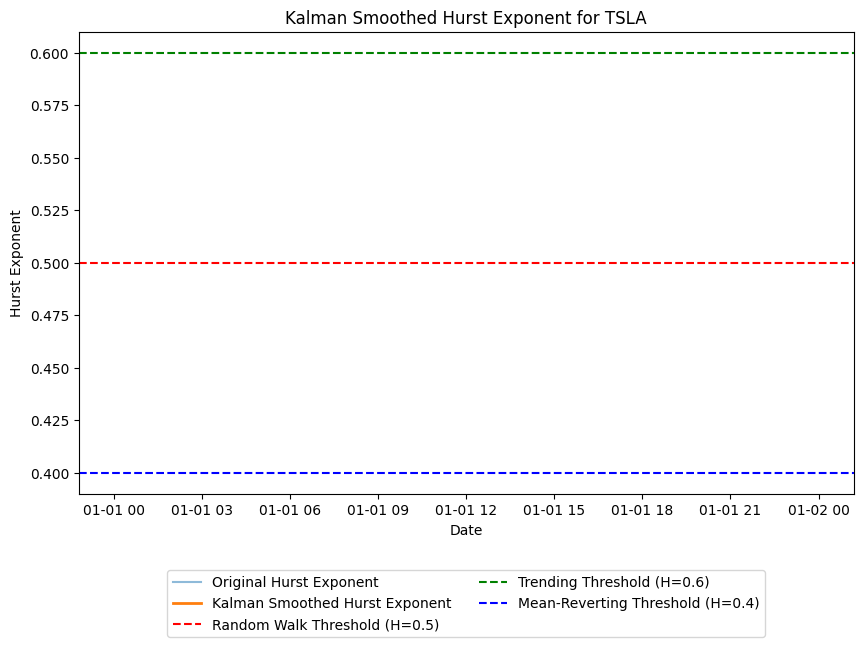

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(hurst_rolling.index, hurst_rolling_smoothed_values, label="Original Hurst Exponent", alpha=0.5)
plt.plot(hurst_rolling.index, hurst_rolling_smoothed, label="Kalman Smoothed Hurst Exponent", linewidth=2)
plt.axhline(0.5, color='red', linestyle='--', label='Random Walk Threshold (H=0.5)')
plt.axhline(0.6, color='green', linestyle='--', label='Trending Threshold (H=0.6)')
plt.axhline(0.4, color='blue', linestyle='--', label='Mean-Reverting Threshold (H=0.4)')
plt.title(f"Kalman Smoothed Hurst Exponent for {ticker}")
plt.xlabel("Date")
plt.ylabel("Hurst Exponent")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.show()

In [ ]:
def baseline_trading_strategy(prices, hurst_roll, sma60, hbuy=0.7, hsell=0.4):
    """
    Baseline trading logic

    Parameters:
        prices (pd.DataFrame): DataFrame of stock prices.
        hurst_roll (pd.DataFrame): DataFrame of rolling Hurst exponent values.
        sma60 (pd.DataFrame): DataFrame of 60-day SMA values.
        hbuy (float): Hurst exponent buy threshold.
        hsell (float): Hurst exponent sell threshold.

    Returns:
        pd.DataFrame: DataFrame with buy/sell signals and positions for each ticker.
    """
    results = pd.DataFrame(index=prices.index, columns=pd.MultiIndex.from_product([prices.columns, ["Signal", "Position"]]))

    for ticker in prices.columns:
        q = 0  # Position: 0 = no position, 1 = long position
        for i in range(len(prices)):
            price = prices[ticker].iloc[i]
            hurst = hurst_roll[ticker].iloc[i]
            sma = sma60[ticker].iloc[i]

            if pd.isna(price) or pd.isna(hurst) or pd.isna(sma):
                continue

            signal = 0
            if q == 0:  # No position
                if price > sma and hurst > hbuy:
                    q = 1
                    signal = 1  # Buy signal
            elif q == 1:  # Long position
                if price < sma or hurst < hsell:
                    q = 0
                    signal = -1  # Sell signal

            results.loc[prices.index[i], (ticker, "Signal")] = signal
            results.loc[prices.index[i], (ticker, "Position")] = q

    return results





In [ ]:
sma_60 = adj_close_SP500.rolling(window=60).mean().fillna(method="ffill").fillna(method="bfill")

hurst_rolling = hurst_rolling.reindex(adj_close_SP500.index).fillna(method="ffill").fillna(method="bfill")
sma_60 = sma_60.reindex(adj_close_SP500.index).fillna(method="ffill").fillna(method="bfill")

<ipython-input-43-caf8a5cc9e9e>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sma_60 = adj_close_SP500.rolling(window=60).mean().fillna(method="ffill").fillna(method="bfill")
<ipython-input-43-caf8a5cc9e9e>:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hurst_rolling = hurst_rolling.reindex(adj_close_SP500.index).fillna(method="ffill").fillna(method="bfill")
<ipython-input-43-caf8a5cc9e9e>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sma_60 = sma_60.reindex(adj_close_SP500.index).fillna(method="ffill").fillna(method="bfill")


In [ ]:
results = baseline_trading_strategy(adj_close_SP500, hurst_rolling, sma_60)

print(results.head())
results.to_csv("baseline_results.csv")

Empty DataFrame
Columns: [(TSLA, Signal), (TSLA, Position)]
Index: []


In [ ]:
# Supertrend trading strategy

In [ ]:

# Calculate True Range (TR)
data['Previous_Close'] = data[('Close', 'TSLA')].shift(1)
data['HL'] = data[('High', 'TSLA')] - data[('Low', 'TSLA')]

data['HC'] = abs(data[('High', 'TSLA')] - data['Previous_Close'])
data['LC'] = abs(data[('Low', 'TSLA')] - data['Previous_Close'])
data['TR'] = data[['HL', 'HC', 'LC']].max(axis=1)  # True Range is max of HL, HC, and LC

# Calculate ATR as rolling mean of TR
atr_period = 10
data['ATR'] = data['TR'].rolling(window=atr_period).mean()



In [ ]:
multiplier = 3
data['Upper_Band'] = data[('Close', 'TSLA')] + (multiplier * data['ATR'])
data['Lower_Band'] = data[('Close', 'TSLA')] - (multiplier * data['ATR'])

In [ ]:
# Initialize SuperTrend column
data['SuperTrend'] = 0.0
in_uptrend = True  # Initial trend direction

# Calculate SuperTrend values iteratively
for i in range(len(data)):
    if i == 0:  # First row
        data.loc[data.index[i], 'SuperTrend'] = data['Lower_Band'].iloc[i]
        continue

    if data[('Close', 'TSLA')].iloc[i] > data['SuperTrend'].iloc[i - 1]:  # Price is above SuperTrend
        in_uptrend = True
    elif data[('Close', 'TSLA')].iloc[i] < data['SuperTrend'].iloc[i - 1]:  # Price is below SuperTrend
        in_uptrend = False

    if in_uptrend:
        data.loc[data.index[i], 'SuperTrend'] = max(
            data['Lower_Band'].iloc[i], data['SuperTrend'].iloc[i - 1]
        )
    else:
        data.loc[data.index[i], 'SuperTrend'] = min(
            data['Upper_Band'].iloc[i], data['SuperTrend'].iloc[i - 1]
        )

# Display the resulting DataFrame with SuperTrend
print(data[['Close', 'ATR', 'Upper_Band', 'Lower_Band', 'SuperTrend']])

Empty DataFrame
Columns: [(Close, TSLA), (ATR, ), (Upper_Band, ), (Lower_Band, ), (SuperTrend, )]
Index: []


In [ ]:
def generate_signals(data, hurst, supertrend, hurst_trend_threshold=0.6, hurst_revert_threshold=0.4):
    """
    Generate trading signals based on Hurst exponent and SuperTrend.

    Parameters:
        data (pd.DataFrame): Input DataFrame containing 'Close' prices.
        hurst (list or np.array): Hurst exponent values.
        supertrend (list or np.array): SuperTrend values.
        hurst_trend_threshold (float): Threshold for trending market.
        hurst_revert_threshold (float): Threshold for mean-reverting market.

    Returns:
        list: List of signals (1 for buy, -1 for sell, 0 for hold).
    """
    signals = []

    for i in range(len(data)):
        # Skip rows with NaN SuperTrend or Hurst values
        if pd.isna(supertrend[i]) or pd.isna(hurst[i]):
            signals.append(2)  # Hold
            continue

        # Trending Market (Hurst > hurst_trend_threshold)
        if hurst[i] > hurst_trend_threshold:
            if data[('Close', 'TSLA')].iloc[i] > supertrend[i]:  # Price > SuperTrend -> Buy
                signals.append(1)
            elif data[('Close', 'TSLA')].iloc[i] < supertrend[i]:  # Price < SuperTrend -> Sell
                signals.append(-1)
            else:
                signals.append(0)

        # Mean-Reverting Market (Hurst < hurst_revert_threshold)
        elif hurst[i] < hurst_revert_threshold:
            signals.append(0)  # Hold in mean-reverting markets

        # Random Market (Hurst ~ 0.5)
        else:
            signals.append(0)  # Hold in uncertain market conditions

    return signals

In [ ]:
# Flatten hurst_rolling if it's a list of lists
try:
    first_value = hurst_rolling.iloc[0].values[0]  # Get the first value
    if isinstance(first_value, list):
        hurst_rolling_flat = [value[0] for value in hurst_rolling.values]
    else:
        hurst_rolling_flat = hurst_rolling.values.flatten()  # Flatten the values
except IndexError:  # Handle empty DataFrame
    hurst_rolling_flat = []

# Align hurst_rolling with data index
hurst_rolling_series = pd.Series(hurst_rolling_flat, index=data.index[:len(hurst_rolling_flat)])
hurst_rolling_aligned = hurst_rolling_series.reindex(data.index).fillna(method='ffill').fillna(method='bfill').tolist()

# Drop rows with NaN in SuperTrend
data = data.dropna(subset=[('SuperTrend', '')])

# Generate signals
signals = generate_signals(data, hurst_rolling_aligned, data[('SuperTrend', '')].tolist())

# Add signals to the DataFrame
data['Signal'] = signals

# Display the results
print(data[['Close', 'SuperTrend', 'Signal']].head(30))


Empty DataFrame
Columns: [(Close, TSLA), (SuperTrend, ), (Signal, )]
Index: []


<ipython-input-50-16aa7e39420a>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hurst_rolling_aligned = hurst_rolling_series.reindex(data.index).fillna(method='ffill').fillna(method='bfill').tolist()


In [ ]:
# Execute backtesting of baseline trading strategy and Hurst+Supertrend trading strategy
# Primary metric is expected return. Consider Sharpe ratio.

In [ ]:
# Get TSLA data
data['SMA_60'] = data['Close'].rolling(window=60).mean()
data['Hurst'] = data['Close'].rolling(window=60).apply(lambda x: hurst_exponent(x, min_window=10), raw=False)

Empty DataFrame
Columns: [(Adj Close, TSLA), (Close, TSLA), (High, TSLA), (Low, TSLA), (Open, TSLA), (Volume, TSLA), (Previous_Close, ), (HL, ), (HC, ), (LC, ), (TR, ), (ATR, ), (Upper_Band, ), (Lower_Band, ), (SuperTrend, ), (Signal, )]
Index: []


In [ ]:
# trading signals using baseline trading strategy
data['Signals'] = baseline_trading_strategy(data, data['SMA_60'], data['Hurst'])

# Backtesting performance
def backtest_strategy(data, signals, initial_balance=100000, risk_per_trade=0.01, atr_period=14):
    balance = initial_balance
    position = 0
    balance_history = []
    data['ATR'] = data['Close'].rolling(window=atr_period).std() * np.sqrt(atr_period)

    for i in range(len(data)):
        price = data['Close'].iloc[i]
        signal = signals[i]
        atr = data['ATR'].iloc[i]

        if signal == 1 and position == 0:  # Buy signal
            risk_amount = balance * risk_per_trade
            stop_loss = price - (2 * atr)
            position_size = risk_amount / (price - stop_loss)

            position = min(position_size, balance / price)
            balance -= position * price

        elif signal == -1 and position > 0:  # Sell signal
            balance += position * price
            position = 0

        balance_history.append(balance + position * price)

    # Calculate performance metrics
    returns = pd.Series(balance_history).pct_change().dropna()
    expected_return = returns.mean() * 252
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(252)

    # Visualization of the backtest
    plt.figure(figsize=(10, 6))
    plt.plot(balance_history, label='Portfolio Value')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Backtesting Performance of Trading Strategy')
    plt.legend()
    plt.show()

    print(f'Expected Return: {expected_return:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}')
    return expected_return, sharpe_ratio



KeyError: 'SMA_60'

In [ ]:
# Execute backtest
expected_return, sharpe_ratio = backtest_strategy(data, data['Signals'])
print(f'Expected Return: {expected_return:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}')